Mobility data saved as 'mobility_data.csv'

=== Plotted Data Only (a/b directions, holes/electrons) ===
Strain Particle  Band Index Direction  Least Squares m* (m_e)  Finite Difference m* (m_e)    EffMass_SI  Mobility (cm²/V·s)
    0%     hole          10   1 -0 -0                 -2.6115                     -1.4261 -2.378916e-30           10.825989
    0%     hole          10     1 0 0                 -0.5399                     -0.6774 -4.918156e-31          253.291726
    0%     hole          10     1 1 0                 -0.6339                     -0.7940 -5.774438e-31          183.741033
    0%     hole          10    1 1 -0                 -2.3661                     -1.5006 -2.155371e-30           13.188077
    0% electron          11   1 -0 -0                  1.4845                      1.5242  1.352288e-30           33.503274
    1%     hole           9   1 -0 -0                 -1.5158                     -3.8784 -1.380800e-30           32.133931
    1%     hole           9 

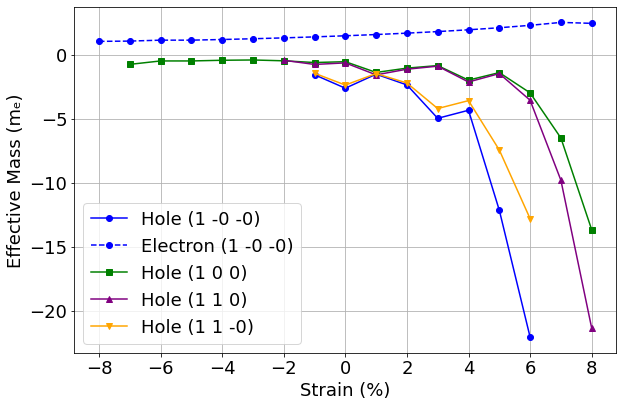

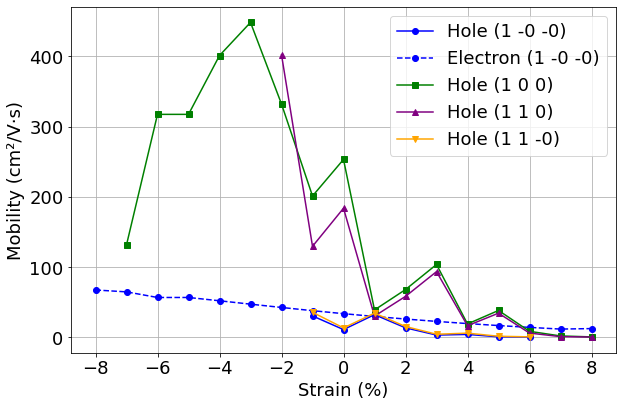

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Apply font size globally
plt.rcParams.update({'font.size': 18})

# ============================
# 1. Load Effective Mass Data
# ============================
effmass_df = pd.read_csv('effmass_data.csv')

# Standardize direction format
effmass_df['Direction'] = (
    effmass_df['Direction'].astype(str)
    .str.replace(r"[\[\]\.]", "", regex=True)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

# Drop missing or invalid values
effmass_df = effmass_df.dropna(subset=['Least Squares m* (m_e)', 'Strain'])
effmass_df['Least Squares m* (m_e)'] = pd.to_numeric(effmass_df['Least Squares m* (m_e)'], errors='coerce')
effmass_df = effmass_df.dropna(subset=['Least Squares m* (m_e)'])

# ============================
# 2. Calculate Mobility
# ============================
# Constants
e_charge = 1.602176634e-19
hbar = 1.054571817e-34
m0 = 9.10938356e-31
kB = 1.380649e-23
T = 300
C = 130  # GPa
E_def = 5.0 * e_charge  # Convert eV to J

# Calculate mobility
effmass_df['EffMass_SI'] = effmass_df['Least Squares m* (m_e)'] * m0
effmass_df['Mobility (cm²/V·s)'] = (
    (2 * e_charge * hbar**3 * C) /  # Convert GPa to N/m²
    (3 * kB * T * effmass_df['EffMass_SI']**2 * E_def**2)
) * 1e4

# Save data
effmass_df.to_csv('mobility_data.csv', index=False)
print("Mobility data saved as 'mobility_data.csv'")

# ============================
# 3. Filter a- and b-directions
# ============================
a_directions = ['1 -0 -0', '1 0 0']
b_directions = ['1 1 0', '1 1 -0']
plot_directions = a_directions + b_directions
particles = ['hole', 'electron']

# Filter for plotted data
plotted_data = effmass_df[effmass_df['Direction'].isin(plot_directions) & effmass_df['Particle'].isin(particles)]

# ============================
# Print Only Plotted Data
# ============================
print("\n=== Plotted Data Only (a/b directions, holes/electrons) ===")
print(plotted_data.to_string(index=False))

# ============================
# 4. Helper Function
# ============================
def get_sorted(data, particle, direction, column):
    subset = data[(data['Particle'] == particle) & (data['Direction'] == direction)]
    strain = subset['Strain'].astype(str).str.replace('%', '').astype(float)
    values = subset[column]
    sorted_indices = np.argsort(strain)
    return strain.iloc[sorted_indices], values.iloc[sorted_indices]

# ============================
# 5. Plot Effective Mass
# ============================
plt.figure(figsize=(9, 6))
for direction, color, marker in zip(plot_directions, ['blue', 'green', 'purple', 'orange'], ['o', 's', '^', 'v']):
    for particle, linestyle in zip(particles, ['-', '--']):
        strain, effmass = get_sorted(effmass_df, particle, direction, 'Least Squares m* (m_e)')
        if not strain.empty:
            plt.plot(strain, effmass, label=f"{particle.capitalize()} ({direction})",
                     marker=marker, linestyle=linestyle, color=color)

plt.xlabel('Strain (%)')
plt.ylabel('Effective Mass (mₑ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('AB_Effmass.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================
# 6. Plot Mobility
# ============================
plt.figure(figsize=(9, 6))
for direction, color, marker in zip(plot_directions, ['blue', 'green', 'purple', 'orange'], ['o', 's', '^', 'v']):
    for particle, linestyle in zip(particles, ['-', '--']):
        strain, mobility = get_sorted(effmass_df, particle, direction, 'Mobility (cm²/V·s)')
        if not strain.empty:
            plt.plot(strain, mobility, label=f"{particle.capitalize()} ({direction})",
                     marker=marker, linestyle=linestyle, color=color)

plt.xlabel('Strain (%)')
plt.ylabel('Mobility (cm²/V·s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('AB_Mobility.png', dpi=300, bbox_inches='tight')
plt.show()
